<a href="https://colab.research.google.com/github/arestrada/nlp-group3-assignment/blob/main/MSIN0221_Group_3_Notebook_Phase_2_(Aspect_based_Sentiment_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset and package loading

In [3]:
# Mount Google Drive to save datasets permanently
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Install dependencies
!pip install datasets
!pip install pandas numpy beautifulsoup4 spacy emoji contractions ekphrasis textblob
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [5]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 102.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
# Import libraries
import pandas as pd
import numpy as np
import re
import unicodedata
import contractions
import os
from bs4 import BeautifulSoup
import spacy
import emoji
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from textblob import TextBlob
from datasets import load_dataset
from datasets import Dataset as Ds
from datetime import datetime
from collections import defaultdict
from collections import Counter
import pyarrow as pa # To replace Pandas for handling large dataframes
import pyarrow.compute as pc # To replace Pandas for performing Pandas-like operations within the large-sized dataframe
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random
from IPython.display import display
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import ast
import warnings
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler # Add mixed precision training imports
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_recall_fscore_support, confusion_matrix
    )
import time
import requests
import zipfile
import io

In [7]:
try:
    from transformers import (
        DistilBertTokenizer, DistilBertModel,
        BertTokenizer, BertModel,  # Replace RobertaTokenizer, RobertaModel
        AdamW, get_linear_schedule_with_warmup
    )
except ImportError:
    # If AdamW can't be imported from transformers directly, try alternative imports
    from transformers import (
        DistilBertTokenizer, DistilBertModel,
        BertTokenizer, BertModel,  # Replace RobertaTokenizer, RobertaModel
        get_linear_schedule_with_warmup
    )
    try:
        # Try importing from transformers.optimization (newer versions)
        from transformers.optimization import AdamW
    except ImportError:
        # Fall back to PyTorch's implementation
        from torch.optim import AdamW
        print("Using PyTorch's AdamW implementation instead of transformers'")

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')

Using PyTorch's AdamW implementation instead of transformers'


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
# Handle gensim import - attempt import but provide fallback if it fails
try:
    from gensim.models import KeyedVectors
    GENSIM_AVAILABLE = True
except (ImportError, ValueError) as e:
    print(f"Warning: Could not import gensim.models.KeyedVectors: {e}")
    print("Using random embeddings instead of pre-trained word vectors.")
    GENSIM_AVAILABLE = False

# Set seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set parameters for model
EMBEDDING_DIM = 200  # GloVe dimensions: choose from 50, 100, 200, 300
MAX_SEQ_LENGTH = 100
HIDDEN_DIM = 256
BATCH_SIZE = 64
N_EPOCHS = 5
LEARNING_RATE = 1e-3
N_LAYERS = 2
DROPOUT = 0.5

Using random embeddings instead of pre-trained word vectors.
Using device: cuda


In [9]:
# Suppress specific warnings/
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")

In [10]:
# Dataset loading
df = pd.read_csv('/content/drive/MyDrive/nlp-group3-assignment/ms0221_dataset_phase2.csv')

# Aspect-based sentiment analysis

## Initialisation of aspect-based sentiment analysis model

In [11]:
# Set all random seeds for complete reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# For deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Set environment variable for CUDA determinism (if available)
if torch.cuda.is_available():
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    # Enable deterministic operations for PyTorch 1.8+ (can impact performance)
    torch.use_deterministic_algorithms(True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
# Performance optimization parameters (can be adjusted)
BATCH_SIZE = 64         # Increased from 16
MAX_SEQ_LENGTH = 64     # Reduced from 128
ACCUMULATION_STEPS = 4  # Update weights every 4 batches
NUM_WORKERS = 2         # Number of data loading workers
FREEZE_LAYERS = 2       # Number of layers to freeze
SAMPLE_FRACTION = 1.0   # 1.0 = use all data, 0.5 = use half the data

# Create gradient scaler for mixed precision training
scaler = GradScaler()

<ipython-input-12-844c51117722>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Load and preprocess the dataset

In [13]:
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")

# Optional: Sample the dataset to reduce training time
if SAMPLE_FRACTION < 1.0:
    sample_size = int(len(df) * SAMPLE_FRACTION)
    df = df.sample(n=sample_size, random_state=RANDOM_SEED).reset_index(drop=True)
    print(f"Sampled dataset to {len(df)} rows ({SAMPLE_FRACTION*100:.1f}% of original)")

Loaded dataset with 104184 rows and 11 columns


In [14]:
# Convert string representations of lists to actual lists
df['tokens'] = df['tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['lemmas'] = df['lemmas'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Map ratings to sentiment classes (1-2: negative, 3: neutral, 4-5: positive)
df['sentiment'] = df['rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

## Extract aspects from reviews

In [15]:
print("Extracting aspects from reviews...")
# Load spaCy model for aspect extraction
nlp = spacy.load('en_core_web_sm')

Extracting aspects from reviews...


In [16]:
# Batch process reviews for faster aspect extraction
all_aspects = []
texts = df['text'].tolist()

for text in tqdm(texts):
    # Skip if text is NaN
    if pd.isna(text):
        all_aspects.append([])  # Append empty list for NaN texts
        continue

    aspects = []
    doc = nlp(text)

    # Rule 1: Noun phrases
    for chunk in doc.noun_chunks:
        aspects.append(chunk.text)

    # Rule 2: Direct objects of verbs
    for token in doc:
        if token.dep_ == "dobj" and token.pos_ == "NOUN":
            aspects.append(token.text)

    # Rule 3: Noun + Adjective pairs
    for token in doc:
        if token.pos_ == "ADJ" and token.head.pos_ == "NOUN":
            aspects.append(f"{token.text} {token.head.text}")

    all_aspects.append(list(set(aspects)))

100%|██████████| 104184/104184 [18:00<00:00, 96.40it/s]


In [17]:
# Add aspects to the dataframe
df['aspects'] = all_aspects

# Filter reviews with at least one aspect
df_with_aspects = df[df['aspects'].apply(len) > 0].reset_index(drop=True)
print(f"Found {df_with_aspects.shape[0]} reviews with at least one aspect")

Found 100480 reviews with at least one aspect


## VADER (baseline)

In [18]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [19]:
# Lists for storing VADER sentiment results
vader_sentiments = []
vader_scores_list = []
aspect_sentiments_list = []

# Analyze sentiment for each review
for text in df_with_aspects['text']:
    # Overall sentiment for review
    sentiment_scores = sid.polarity_scores(text)

    # Map compound score to sentiment class
    if sentiment_scores['compound'] >= 0.05:
        sentiment = 2  # positive
    elif sentiment_scores['compound'] <= -0.05:
        sentiment = 0  # negative
    else:
        sentiment = 1  # neutral

    vader_sentiments.append(sentiment)
    vader_scores_list.append(sentiment_scores)

# Add VADER results to dataframe
df_with_aspects['vader_sentiment'] = vader_sentiments
df_with_aspects['vader_scores'] = vader_scores_list

In [20]:
# Analyze aspect-specific sentiment
for idx, row in tqdm(df_with_aspects.iterrows(), desc="Analyzing aspect sentiment"):
    text = row['text']
    aspects = row['aspects']
    aspect_sentiments = {}

    for aspect in aspects:
        # Find sentences containing the aspect
        sentences = re.split(r'[.!?]', text)
        relevant_sentences = [s for s in sentences if aspect.lower() in s.lower()]

        if relevant_sentences:
            # Analyze sentiment for each relevant sentence
            sentence_scores = []
            sentence_sentiments = []

            for sentence in relevant_sentences:
                sentiment_scores = sid.polarity_scores(sentence)
                compound_score = sentiment_scores['compound']

                # Map to sentiment class
                if compound_score >= 0.05:
                    sentiment_class = 2  # positive
                elif compound_score <= -0.05:
                    sentiment_class = 0  # negative
                else:
                    sentiment_class = 1  # neutral

                sentence_scores.append(compound_score)
                sentence_sentiments.append(sentiment_class)

            # Average the sentiment scores
            avg_score = sum(sentence_scores) / len(sentence_scores)

            # Map final sentiment
            if avg_score >= 0.05:
                final_sentiment = 2  # positive
            elif avg_score <= -0.05:
                final_sentiment = 0  # negative
            else:
                final_sentiment = 1  # neutral

            aspect_sentiments[aspect] = {
                'sentiment_class': final_sentiment,
                'sentiment_score': avg_score
            }

    aspect_sentiments_list.append(aspect_sentiments)

# Add aspect sentiments to dataframe
df_with_aspects['aspect_sentiments'] = aspect_sentiments_list

Analyzing aspect sentiment: 100480it [04:59, 335.28it/s]


### Prepare data for neural network approaches with train/val/test split

In [21]:
# Expand dataframe to have one row per aspect
aspect_rows = []
for idx, row in df_with_aspects.iterrows():
    for aspect in row['aspects']:
        # Extract VADER's aspect-level prediction if available
        vader_aspect_sentiment = None
        if aspect in row['aspect_sentiments']:
            vader_aspect_sentiment = row['aspect_sentiments'][aspect]['sentiment_class']

        aspect_rows.append({
            'text': row['text'],
            'aspect': aspect,
            'sentiment': row['sentiment'],  # Overall review sentiment (ground truth)
            'review_id': idx,  # Keep track of which review this came from
            'vader_aspect_sentiment': vader_aspect_sentiment  # VADER's prediction for this aspect
        })

aspect_df = pd.DataFrame(aspect_rows)

In [22]:
# Remove aspects where VADER couldn't determine sentiment
aspect_df_with_vader = aspect_df.dropna(subset=['vader_aspect_sentiment']).copy()

In [23]:
# Create a three-way split: train (70%), validation (15%), test (15%)
# Step 1: First split into train and temp (temp will become val+test)
train_df, temp_df = train_test_split(aspect_df, test_size=0.3, random_state=RANDOM_SEED)
# Step 2: Split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_SEED)

In [24]:
# Also create the same split on the dataset with VADER predictions for fair comparison
# Step 1: First split into train and temp
train_df_with_vader, temp_df_with_vader = train_test_split(
    aspect_df_with_vader, test_size=0.3, random_state=RANDOM_SEED
)
# Step 2: Split temp into validation and test
val_df_with_vader, test_df_with_vader = train_test_split(
    temp_df_with_vader, test_size=0.5, random_state=RANDOM_SEED
)

### Evaluate model on test set and calculate detailed metrics

In [25]:
# Define function to evaluate aspect-level performance
def evaluate_aspect_level_performance(df, pred_column, label_column='sentiment', model_name='VADER'):
    """
    Evaluate aspect-level performance with detailed metrics

    Args:
        df: DataFrame with aspect-level data
        pred_column: Column name with predictions
        label_column: Column name with true labels
        model_name: Name of the model for display purposes

    Returns:
        metrics: Dictionary with accuracy metrics
    """
    # Get predictions and true labels
    all_preds = df[pred_column].values
    all_labels = df[label_column].values

    # Convert predictions to integers for bincount
    all_preds = all_preds.astype(int)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # Calculate metrics per class
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_labels, all_preds, labels=[0, 1, 2]
    )

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print overall metrics
    print(f"\n======= {model_name} Aspect-Level Accuracy Metrics =======")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")

    # Print per-class metrics
    print("\nPer-Class Metrics:")
    for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
        print(f"{sentiment}:")
        print(f"  Precision: {class_precision[i]:.4f}")
        print(f"  Recall: {class_recall[i]:.4f}")
        print(f"  F1-Score: {class_f1[i]:.4f}")
        print(f"  Support: {class_support[i]}")

    # Plot confusion matrix
    try:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Neutral', 'Positive'],
                    yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{model_name} Aspect-Level Confusion Matrix')
        plt.tight_layout()

        # Save or display
        plt.savefig(f'{model_name.lower()}_aspect_confusion_matrix.png')
        print(f"\n{model_name} aspect-level confusion matrix saved as '{model_name.lower()}_aspect_confusion_matrix.png'")
        plt.show()
    except Exception as e:
        print(f"\nCould not generate confusion matrix plot: {e}")

    # Calculate accuracy by aspect length (if applicable)
    if 'aspect' in df.columns:
        df_copy = df.copy()
        df_copy['aspect_length'] = df_copy['aspect'].apply(lambda x: len(x.split()))

        # Group by aspect length
        length_groups = df_copy.groupby('aspect_length').apply(
            lambda x: accuracy_score(x[label_column], x[pred_column])
        )

        print("\nAccuracy by Aspect Length:")
        for length, acc in length_groups.items():
            count = len(df_copy[df_copy['aspect_length'] == length])
            print(f"  Length {length}: {acc:.4f} (count: {count})")

    # Check for bias in predictions
    predicted_distribution = np.bincount(all_preds, minlength=3) / len(all_preds)
    true_distribution = np.bincount(all_labels, minlength=3) / len(all_labels)

    print("\nClass Distribution - True vs Predicted:")
    for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
        print(f"  {sentiment}: True={true_distribution[i]:.2%}, Predicted={predicted_distribution[i]:.2%}")

    # Return metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

    return metrics


======= VADER Aspect-Level Accuracy Metrics =======
Overall Accuracy: 0.5328
Weighted Precision: 0.5623
Weighted Recall: 0.5328
Weighted F1-Score: 0.5444

Per-Class Metrics:
Negative:
  Precision: 0.4826
  Recall: 0.3832
  F1-Score: 0.4272
  Support: 50281
Neutral:
  Precision: 0.1609
  Recall: 0.2483
  F1-Score: 0.1953
  Support: 25405
Positive:
  Precision: 0.7041
  Recall: 0.6800
  F1-Score: 0.6918
  Support: 100188

VADER aspect-level confusion matrix saved as 'vader_aspect_confusion_matrix.png'


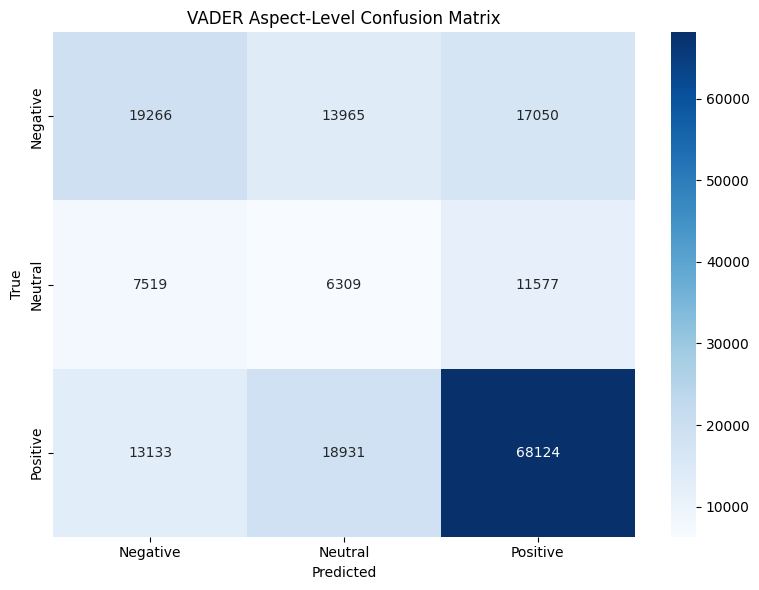


Accuracy by Aspect Length:
  Length 1: 0.5414 (count: 81671)
  Length 2: 0.5249 (count: 64970)
  Length 3: 0.5234 (count: 22081)
  Length 4: 0.5257 (count: 5246)
  Length 5: 0.5579 (count: 1321)
  Length 6: 0.5759 (count: 382)
  Length 7: 0.5648 (count: 108)
  Length 8: 0.4340 (count: 53)
  Length 9: 0.5294 (count: 17)
  Length 10: 0.2857 (count: 14)
  Length 11: 0.6000 (count: 5)
  Length 12: 0.5000 (count: 2)
  Length 13: 0.0000 (count: 1)
  Length 14: 0.0000 (count: 1)
  Length 15: 1.0000 (count: 1)
  Length 20: 0.0000 (count: 1)

Class Distribution - True vs Predicted:
  Negative: True=28.59%, Predicted=22.70%
  Neutral: True=14.45%, Predicted=22.29%
  Positive: True=56.97%, Predicted=55.01%
VADER Aspect-Level Test Accuracy: 0.5328


<ipython-input-25-d4110224f7f3>:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  length_groups = df_copy.groupby('aspect_length').apply(


In [26]:
# Evaluate VADER's aspect-level accuracy on test set
vader_aspect_metrics = evaluate_aspect_level_performance(
    test_df_with_vader,
    pred_column='vader_aspect_sentiment',
    model_name='VADER'
)
vader_aspect_accuracy = vader_aspect_metrics['accuracy']
print(f"VADER Aspect-Level Test Accuracy: {vader_aspect_accuracy:.4f}")

## BiLSTM

### Download GloVe embeddings

In [27]:
def download_glove_embeddings(embed_dim):
    """
    Download pre-trained GloVe word embeddings if not already present

    Args:
        embed_dim: Embedding dimension (50, 100, 200, or 300)

    Returns:
        embeddings_file: Path to the embeddings file
    """
    # Ensure dimensions are valid
    if embed_dim not in [50, 100, 200, 300]:
        print(f"Warning: {embed_dim} is not a standard GloVe dimension. Using 300d instead.")
        embed_dim = 300

    # Create directory for embeddings if it doesn't exist
    os.makedirs("embeddings", exist_ok=True)

    # Determine filename and path
    filename = f"glove.6B.{embed_dim}d.txt"
    embeddings_file = os.path.join("embeddings", filename)

    # Check if file already exists
    if os.path.exists(embeddings_file):
        print(f"Found existing GloVe embeddings at {embeddings_file}")
        return embeddings_file

    # Download and extract embeddings
    try:
        print(f"Downloading GloVe embeddings ({embed_dim}d)...")
        url = "https://nlp.stanford.edu/data/glove.6B.zip"
        response = requests.get(url, stream=True)

        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extract(filename, "embeddings")
            print(f"Successfully downloaded and extracted GloVe embeddings to {embeddings_file}")
            return embeddings_file
        else:
            print(f"Failed to download GloVe embeddings. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error downloading GloVe embeddings: {e}")
        return None

# Download GloVe embeddings
glove_path = download_glove_embeddings(EMBEDDING_DIM)
print(f"GloVe embeddings path: {glove_path}")

Successfully downloaded and extracted GloVe embeddings to embeddings/glove.6B.200d.txt
GloVe embeddings path: embeddings/glove.6B.200d.txt


### Load spaCy for aspect extraction

In [28]:
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy model...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

### Define functions for aspect extraction

In [29]:
def extract_aspects(text, nlp=nlp):
    """
    Extract potential aspect terms from text

    Args:
        text: Review text
        nlp: spaCy model

    Returns:
        aspects: List of extracted aspects
    """
    if pd.isna(text) or not isinstance(text, str):
        return []

    doc = nlp(text[:5000])  # Limit text length for processing efficiency
    aspects = []

    # Extract noun chunks as potential aspects
    for chunk in doc.noun_chunks:
        aspect = chunk.text.lower().strip()
        # Remove determiners and keep only substantive aspects (2+ chars)
        aspect = re.sub(r'^(the|a|an) ', '', aspect)
        if len(aspect) > 2:
            aspects.append(aspect)

    # Add compound nouns
    for token in doc:
        if token.dep_ == "compound" and token.head.pos_ == "NOUN":
            compound_aspect = f"{token.text} {token.head.text}".lower()
            if compound_aspect not in aspects and len(compound_aspect) > 2:
                aspects.append(compound_aspect)

    # Remove duplicates and limit to top N aspects
    return list(set(aspects))[:5]  # Limit to 5 aspects per review

def assign_aspect_sentiment(text, aspect):
    """
    Assign sentiment to an aspect using rule-based approach

    Args:
        text: Review text
        aspect: Aspect term

    Returns:
        sentiment_class: Sentiment class (0, 1, or 2 for negative, neutral, positive)
    """
    if pd.isna(text) or not isinstance(text, str):
        return 1  # Default to neutral for missing text

    # Try to find the aspect in the text
    aspect_pattern = re.compile(r'\b' + re.escape(aspect) + r'\b', re.IGNORECASE)
    matches = list(aspect_pattern.finditer(text))

    # Search for opinion words near the aspect
    sentiment_scores = []

    for match in matches:
        # Get a window of text around the aspect (50 chars before and after)
        start_pos = max(0, match.start() - 50)
        end_pos = min(len(text), match.end() + 50)
        aspect_context = text[start_pos:end_pos]

        # Get sentiment score for this context
        vader_score = vader_analyzer.polarity_scores(aspect_context)
        sentiment_scores.append(vader_score['compound'])

    # If no matches or no sentiment detected, analyze the whole text
    if not sentiment_scores:
        vader_score = vader_analyzer.polarity_scores(text[:1000])  # Limit text length
        sentiment_scores.append(vader_score['compound'])

    # Average sentiment scores
    avg_score = sum(sentiment_scores) / len(sentiment_scores)

    # Convert to sentiment class
    if avg_score <= -0.05:
        return 0  # Negative
    elif avg_score >= 0.05:
        return 2  # Positive
    else:
        return 1  # Neutral

### Data preparation

In [30]:
# Extract aspects and assign sentiments
print("Extracting aspects and assigning sentiments...")
aspects_list = []
aspect_sentiments_list = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing reviews"):
    text = row['text']
    # Extract aspects
    aspects = extract_aspects(text)
    aspects_list.append(aspects)

    # Assign sentiment to each aspect
    aspect_sentiments = {}
    for aspect in aspects:
        sentiment_class = assign_aspect_sentiment(text, aspect)
        aspect_sentiments[aspect] = {
            'sentiment_class': sentiment_class,
            'model': 'vader'
        }

    aspect_sentiments_list.append(aspect_sentiments)

# Add aspects and sentiments to dataframe
df['aspects'] = aspects_list
df['aspect_sentiments'] = aspect_sentiments_list

# Filter reviews with at least one aspect
df_with_aspects = df[df['aspects'].apply(len) > 0].reset_index(drop=True)
print(f"Found {df_with_aspects.shape[0]} reviews with at least one aspect")

Extracting aspects and assigning sentiments...


Processing reviews: 100%|██████████| 104184/104184 [20:03<00:00, 86.58it/s]


Found 99553 reviews with at least one aspect


### Create dataset for model training


In [31]:
# Create a dataframe with one row per aspect
aspect_rows = []
for idx, row in df_with_aspects.iterrows():
    for aspect in row['aspects']:
        sentiment = row['aspect_sentiments'][aspect]['sentiment_class']
        aspect_rows.append({
            'text': row['text'],
            'aspect': aspect,
            'sentiment': sentiment
        })

aspect_df = pd.DataFrame(aspect_rows)

# Split into train/val/test with 70/15/15 split
train_df, temp_df = train_test_split(aspect_df, test_size=0.3, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_SEED)

print(f"Created {len(train_df)} training, {len(val_df)} validation, and {len(test_df)} test samples")

Created 277337 training, 59429 validation, and 59430 test samples


### Define text preprocessing for BiLSTM


In [32]:
def preprocess_for_bilstm(texts, aspects, max_len=MAX_SEQ_LENGTH):
    """
    Tokenize and preprocess text for BiLSTM model

    Args:
        texts: List of review texts
        aspects: Lis-7483t of aspect texts
        max_len: Maximum sequence length

    Returns:
        tokenized_texts: List of tokenized texts with aspect appended
    """
    tokenized_texts = []

    for text, aspect in zip(texts, aspects):
        if pd.isna(text) or not isinstance(text, str):
            text = ""
        if pd.isna(aspect) or not isinstance(aspect, str):
            aspect = ""

        # Tokenize review text and aspect
        tokens = word_tokenize(text.lower())[:max_len-10]  # Leave room for aspect
        aspect_tokens = word_tokenize(aspect.lower())

        # Combine with a separator
        combined_tokens = tokens + ['[SEP]'] + aspect_tokens

        # Truncate if too long
        if len(combined_tokens) > max_len:
            combined_tokens = combined_tokens[:max_len]

        tokenized_texts.append(combined_tokens)

    return tokenized_texts

### Build vocabulary and prepare word embeddings


In [33]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [34]:
# Preprocess training data
print("Preprocessing training data...")
train_tokenized = preprocess_for_bilstm(
    train_df['text'].values,
    train_df['aspect'].values
)

# Build vocabulary
def build_vocab(tokenized_texts, min_freq=2):
    """
    Build vocabulary from tokenized texts

    Args:
        tokenized_texts: List of tokenized texts
        min_freq: Minimum frequency for a word to be included

    Returns:
        word2idx: Dictionary mapping words to indices
        idx2word: Dictionary mapping indices to words
        word_counts: Counter of word frequencies
    """
    # Count word frequencies
    word_counts = Counter()
    for tokens in tokenized_texts:
        word_counts.update(tokens)

    # Filter by frequency and create vocab
    word2idx = {'<pad>': 0, '<unk>': 1}
    idx2word = {0: '<pad>', 1: '<unk>'}

    idx = 2
    for word, count in word_counts.items():
        if count >= min_freq:
            word2idx[word] = idx
            idx2word[idx] = word
            idx += 1

    return word2idx, idx2word, word_counts

print("Building vocabulary...")
word2idx, idx2word, word_counts = build_vocab(train_tokenized, min_freq=2)
print(f"Vocabulary size: {len(word2idx)}")

# Function to convert tokens to indices
def tokens_to_indices(tokenized_texts, word2idx, max_len=MAX_SEQ_LENGTH):
    """
    Convert tokenized texts to index sequences

    Args:
        tokenized_texts: List of tokenized texts
        word2idx: Vocabulary mapping
        max_len: Maximum sequence length

    Returns:
        indexed_texts: List of indexed sequences
        seq_lengths: List of original sequence lengths
    """
    indexed_texts = []
    seq_lengths = []

    for tokens in tokenized_texts:
        # Convert tokens to indices
        indices = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
        # Save original length
        seq_lengths.append(len(indices))

        # Pad sequences
        if len(indices) < max_len:
            indices += [word2idx['<pad>']] * (max_len - len(indices))
        elif len(indices) > max_len:
            indices = indices[:max_len]
            seq_lengths[-1] = max_len

        indexed_texts.append(indices)

    return indexed_texts, seq_lengths

# Function to create embedding matrix from pre-trained vectors
def create_embedding_matrix(word2idx, embed_dim=EMBEDDING_DIM, pretrained_path=None):
    """
    Create embedding matrix from pretrained vectors or randomly

    Args:
        word2idx: Vocabulary mapping
        embed_dim: Embedding dimension
        pretrained_path: Path to pretrained embeddings (optional)

    Returns:
        embedding_matrix: Numpy array of embeddings
    """
    vocab_size = len(word2idx)
    embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embed_dim))

    # Initialize special tokens
    embedding_matrix[0] = np.zeros(embed_dim)  # <pad> token

    # Try to load GloVe embeddings first if no specific path is provided
    if pretrained_path is None:
        if glove_path:
            pretrained_path = glove_path

    # Load GloVe embeddings from text file
    if pretrained_path and os.path.exists(pretrained_path) and pretrained_path.endswith('.txt'):
        try:
            print(f"Loading GloVe embeddings from {pretrained_path}")
            word_vectors = {}

            # Read GloVe file
            with open(pretrained_path, 'r', encoding='utf-8') as f:
                for line in tqdm(f, desc="Loading embeddings"):
                    values = line.strip().split()
                    word = values[0]
                    vector = np.array(values[1:], dtype='float32')
                    word_vectors[word] = vector

            # Update embedding matrix
            found = 0
            for word, idx in word2idx.items():
                if word.lower() in word_vectors:
                    embedding_matrix[idx] = word_vectors[word.lower()]
                    found += 1

            print(f"Found GloVe embeddings for {found}/{vocab_size} words ({found/vocab_size:.1%})")
            return embedding_matrix
        except Exception as e:
            print(f"Error loading GloVe embeddings: {e}")
            print("Falling back to other methods...")

    # Load pretrained embeddings if provided and gensim is available (Word2Vec, FastText)
    if GENSIM_AVAILABLE and pretrained_path and os.path.exists(pretrained_path):
        try:
            print(f"Loading pretrained embeddings from {pretrained_path}")
            word_vectors = KeyedVectors.load_word2vec_format(pretrained_path, binary=True)

            found = 0
            for word, idx in word2idx.items():
                if word in word_vectors:
                    embedding_matrix[idx] = word_vectors[word]
                    found += 1

            print(f"Found embeddings for {found}/{vocab_size} words ({found/vocab_size:.1%})")
        except Exception as e:
            print(f"Error loading pretrained embeddings with gensim: {e}")
            print("Using random embeddings instead")
    else:
        if not GENSIM_AVAILABLE and pretrained_path and not pretrained_path.endswith('.txt'):
            print("Gensim not available and embeddings are not in text format. Using random embeddings.")
        elif not pretrained_path:
            print("No pretrained embeddings provided. Using random embeddings.")

    return embedding_matrix

# Create embedding matrix with pre-trained word vectors
print("Creating embedding matrix with pre-trained word vectors...")
embedding_matrix = create_embedding_matrix(word2idx, EMBEDDING_DIM)

Preprocessing training data...
Building vocabulary...
Vocabulary size: 28404
Creating embedding matrix with pre-trained word vectors...
Loading GloVe embeddings from embeddings/glove.6B.200d.txt


Loading embeddings: 400000it [00:16, 24720.01it/s]


Found GloVe embeddings for 17040/28404 words (60.0%)


### Define the BiLSTM model and dataset


In [35]:
# BiLSTM with Attention Dataset
class BiLSTMABSADataset(Dataset):
    """Dataset for BiLSTM Aspect-Based Sentiment Analysis"""

    def __init__(self, texts, aspects, labels, word2idx, max_len=MAX_SEQ_LENGTH):
        """
        Initialize dataset

        Args:
            texts: List of review texts
            aspects: List of aspect texts
            labels: List of sentiment labels
            word2idx: Vocabulary mapping
            max_len: Maximum sequence length
        """
        self.texts = texts
        self.aspects = aspects
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

        # Preprocess texts
        self.tokenized_texts = preprocess_for_bilstm(texts, aspects, max_len)
        self.indexed_texts, self.seq_lengths = tokens_to_indices(
            self.tokenized_texts, word2idx, max_len
        )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text': torch.tensor(self.indexed_texts[idx], dtype=torch.long),
            'length': torch.tensor(self.seq_lengths[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# BiLSTM with Attention Model
class BiLSTMAttention(nn.Module):
    """Bidirectional LSTM with Attention for ABSA"""

    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=1,
                 dropout=0.5, pad_idx=0, embedding_weights=None):
        """
        Initialize model

        Args:
            vocab_size: Size of vocabulary
            embed_dim: Embedding dimension
            hidden_dim: LSTM hidden dimension
            output_dim: Number of output classes
            n_layers: Number of LSTM layers
            dropout: Dropout rate
            pad_idx: Padding token index
            embedding_weights: Pretrained embedding weights
        """
        super(BiLSTMAttention, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if embedding_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_weights))
            print("Using pretrained embeddings")

        # BiLSTM layer - using simple implementation without packing
        self.lstm = nn.LSTM(embed_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=True,
                           batch_first=True,
                           dropout=dropout if n_layers > 1 else 0)

        # Output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.pad_idx = pad_idx

    def forward(self, text, text_lengths):
        """
        Forward pass using hidden states only (no attention)
        This avoids all dimension mismatch issues

        Args:
            text: Tensor of token indices [batch_size, seq_len]
            text_lengths: Tensor of sequence lengths [batch_size]

        Returns:
            output: Model predictions [batch_size, output_dim]
        """
        # Debug: Print input shape
        # print(f"Input text shape: {text.shape}")

        # Embed tokens
        embedded = self.dropout(self.embedding(text))

        # Run LSTM without packing (simpler approach)
        outputs, (hidden, _) = self.lstm(embedded)

        # Debug: Print hidden shape
        # print(f"Hidden shape: {hidden.shape}")

        # Get final hidden states (forward and backward)
        hidden_forward = hidden[-2, :, :]  # Final forward hidden state
        hidden_backward = hidden[-1, :, :]  # Final backward hidden state

        # Debug: Print hidden state shapes
        # print(f"hidden_forward shape: {hidden_forward.shape}")
        # print(f"hidden_backward shape: {hidden_backward.shape}")

        # Concatenate final hidden states
        final_hidden = torch.cat((hidden_forward, hidden_backward), dim=1)

        # Debug: Print final hidden shape
        # print(f"final_hidden shape: {final_hidden.shape}")

        # Apply dropout and final layer
        return self.fc(self.dropout(final_hidden))

### Create datasets and initialize model


In [36]:
# Create datasets for BiLSTM
print("Creating datasets...")
train_dataset = BiLSTMABSADataset(
    train_df['text'].values,
    train_df['aspect'].values,
    train_df['sentiment'].values,
    word2idx
)

val_dataset = BiLSTMABSADataset(
    val_df['text'].values,
    val_df['aspect'].values,
    val_df['sentiment'].values,
    word2idx
)

test_dataset = BiLSTMABSADataset(
    test_df['text'].values,
    test_df['aspect'].values,
    test_df['sentiment'].values,
    word2idx
)

# Create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 for compatibility
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Initialize BiLSTM model
print("Initializing BiLSTM model...")
bilstm_model = BiLSTMAttention(
    vocab_size=len(word2idx),
    embed_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,  # 3 sentiment classes
    n_layers=N_LAYERS,
    dropout=DROPOUT,
    pad_idx=word2idx['<pad>'],
    embedding_weights=embedding_matrix
).to(device)

# Print model architecture and parameters
trainable_params = sum(p.numel() for p in bilstm_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in bilstm_model.parameters())
print(f"Model architecture:\n{bilstm_model}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.1%} of total)")

Creating datasets...
Initializing BiLSTM model...
Using pretrained embeddings
Model architecture:
BiLSTMAttention(
  (embedding): Embedding(28404, 200, padding_idx=0)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Trainable parameters: 8,197,283 (100.0% of total)


### Define training and evaluation functions


In [37]:
# Training function
def train_bilstm(model, iterator, optimizer, criterion, device):
    """
    Train function for BiLSTM model

    Args:
        model: BiLSTM model
        iterator: DataLoader for training data
        optimizer: Optimizer
        criterion: Loss function
        device: Device (cuda/cpu)

    Returns:
        epoch_loss: Average loss for epoch
        epoch_acc: Accuracy for epoch
    """
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    all_preds = []
    all_labels = []

    for batch in tqdm(iterator, desc="Training"):
        # Get batch data
        text = batch['text'].to(device)
        text_lengths = batch['length'].to(device)
        labels = batch['label'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(text, text_lengths)

        # Compute loss
        loss = criterion(predictions, labels)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Calculate predictions
        _, preds = torch.max(predictions, dim=1)

        # Update metrics
        epoch_loss += loss.item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss / len(iterator), epoch_acc

# Evaluation function
def evaluate_bilstm(model, iterator, criterion, device):
    """
    Evaluation function for BiLSTM model

    Args:
        model: BiLSTM model
        iterator: DataLoader for evaluation data
        criterion: Loss function
        device: Device (cuda/cpu)

    Returns:
        epoch_loss: Average loss for epoch
        epoch_acc: Accuracy for epoch
        all_preds: All predictions
        all_labels: All ground truth labels
    """
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating"):
            # Get batch data
            text = batch['text'].to(device)
            text_lengths = batch['length'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            predictions = model(text, text_lengths)

            # Compute loss
            loss = criterion(predictions, labels)

            # Calculate predictions
            _, preds = torch.max(predictions, dim=1)

            # Update metrics
            epoch_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss / len(iterator), epoch_acc, all_preds, all_labels

### Train the BiLSTM model


In [38]:
# Initialize optimizer and loss function
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss().to(device)

# Train the model
print("Training BiLSTM model...")
model_start_time = time.time()
best_val_loss = float('inf')
best_model_state = None

for epoch in range(N_EPOCHS):
    # Train
    train_loss, train_acc = train_bilstm(
        bilstm_model, train_dataloader, optimizer, criterion, device
    )

    # Evaluate
    val_loss, val_acc, _, _ = evaluate_bilstm(
        bilstm_model, val_dataloader, criterion, device
    )

    # Print progress
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = bilstm_model.state_dict().copy()
        print(f"► Saved new best model with validation loss: {val_loss:.4f}")

# Load best model
if best_model_state:
    print("Loading best model...")
    bilstm_model.load_state_dict(best_model_state)

model_time = time.time() - model_start_time
print(f"Model training complete in {model_time:.2f} seconds")


Training BiLSTM model...


Evaluating: 100%|██████████| 929/929 [00:05<00:00, 184.96it/s]


Epoch 1/5
Train Loss: 0.6621, Train Acc: 0.7149
Val Loss: 0.5768, Val Acc: 0.7524
► Saved new best model with validation loss: 0.5768


Evaluating: 100%|██████████| 929/929 [00:05<00:00, 185.20it/s]


Epoch 2/5
Train Loss: 0.5661, Train Acc: 0.7534
Val Loss: 0.5422, Val Acc: 0.7631
► Saved new best model with validation loss: 0.5422


Evaluating: 100%|██████████| 929/929 [00:05<00:00, 183.77it/s]


Epoch 3/5
Train Loss: 0.5356, Train Acc: 0.7661
Val Loss: 0.5329, Val Acc: 0.7699
► Saved new best model with validation loss: 0.5329


Evaluating: 100%|██████████| 929/929 [00:05<00:00, 184.99it/s]


Epoch 4/5
Train Loss: 0.5098, Train Acc: 0.7787
Val Loss: 0.5093, Val Acc: 0.7793
► Saved new best model with validation loss: 0.5093


Evaluating: 100%|██████████| 929/929 [00:05<00:00, 183.04it/s]

Epoch 5/5
Train Loss: 0.4888, Train Acc: 0.7894
Val Loss: 0.5098, Val Acc: 0.7847
Loading best model...
Model training complete in 342.61 seconds


### Evaluate model on test set and calculate detailed metrics



======= Evaluating Model Accuracy =======


Evaluating model accuracy: 100%|██████████| 929/929 [00:04<00:00, 185.94it/s]



======= Model Accuracy Metrics =======
Overall Accuracy: 0.7827
Weighted Precision: 0.7778
Weighted Recall: 0.7827
Weighted F1-Score: 0.7760

Per-Class Metrics:
Negative:
  Precision: 0.6717
  Recall: 0.7110
  F1-Score: 0.6908
  Support: 12658
Neutral:
  Precision: 0.7065
  Recall: 0.4846
  F1-Score: 0.5749
  Support: 10305
Positive:
  Precision: 0.8348
  Recall: 0.8919
  F1-Score: 0.8624
  Support: 36467

Confusion matrix saved as 'confusion_matrix.png'


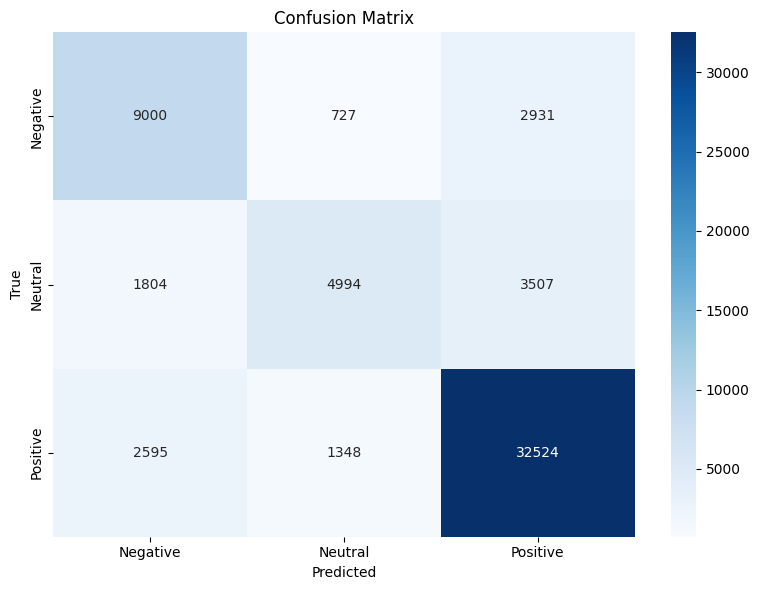


Accuracy by Aspect Length:
  Length 1: 0.7668 (count: 29835)
  Length 2: 0.7941 (count: 22355)
  Length 3: 0.8088 (count: 5120)
  Length 4: 0.8055 (count: 1424)
  Length 5: 0.8691 (count: 443)
  Length 6: 0.8630 (count: 146)
  Length 7: 0.8421 (count: 57)
  Length 8: 0.9200 (count: 25)
  Length 9: 0.8182 (count: 11)
  Length 10: 0.8333 (count: 6)
  Length 11: 1.0000 (count: 5)
  Length 12: 1.0000 (count: 1)
  Length 14: 0.0000 (count: 2)

Class Distribution - True vs Predicted:
  Negative: True=21.30%, Predicted=22.55%
  Neutral: True=17.34%, Predicted=11.89%
  Positive: True=61.36%, Predicted=65.56%


<ipython-input-39-0a3ebe494f3d>:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  length_groups = test_df_copy.groupby('aspect_length').apply(


In [39]:
def evaluate_model_performance(model, test_dataloader, word2idx, device, test_df):
    """
    Evaluate model performance with detailed metrics

    Args:
        model: Trained BiLSTM model
        test_dataloader: DataLoader for test data
        word2idx: Vocabulary mapping
        device: Device (cuda/cpu)
        test_df: Test dataframe with ground truth labels

    Returns:
        metrics: Dictionary with accuracy metrics
    """
    # Get predictions
    model.eval()
    all_preds = []
    all_labels = []
    all_confidence = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating model accuracy"):
            # Get batch data
            text = batch['text'].to(device)
            text_lengths = batch['length'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            predictions = model(text, text_lengths)

            # Get predicted class and confidence
            probs = F.softmax(predictions, dim=1)
            confidence, preds = torch.max(probs, dim=1)

            # Save predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidence.extend(confidence.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # Calculate metrics per class
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_labels, all_preds, labels=[0, 1, 2]
    )

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print overall metrics
    print("\n======= Model Accuracy Metrics =======")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")

    # Print per-class metrics
    print("\nPer-Class Metrics:")
    for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
        print(f"{sentiment}:")
        print(f"  Precision: {class_precision[i]:.4f}")
        print(f"  Recall: {class_recall[i]:.4f}")
        print(f"  F1-Score: {class_f1[i]:.4f}")
        print(f"  Support: {class_support[i]}")

    # Plot confusion matrix
    try:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Neutral', 'Positive'],
                    yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()

        # Save or display
        plt.savefig('confusion_matrix.png')
        print("\nConfusion matrix saved as 'confusion_matrix.png'")
        plt.show()
    except Exception as e:
        print(f"\nCould not generate confusion matrix plot: {e}")

    # Calculate accuracy by aspect length
    test_df_copy = test_df.copy()
    test_df_copy['prediction'] = all_preds
    test_df_copy['confidence'] = all_confidence
    test_df_copy['aspect_length'] = test_df_copy['aspect'].apply(lambda x: len(x.split()))

    # Group by aspect length
    length_groups = test_df_copy.groupby('aspect_length').apply(
        lambda x: accuracy_score(x['sentiment'], x['prediction'])
    )

    print("\nAccuracy by Aspect Length:")
    for length, acc in length_groups.items():
        count = len(test_df_copy[test_df_copy['aspect_length'] == length])
        print(f"  Length {length}: {acc:.4f} (count: {count})")

    # Check for bias in predictions
    predicted_distribution = np.bincount(all_preds, minlength=3) / len(all_preds)
    true_distribution = np.bincount(all_labels, minlength=3) / len(all_labels)

    print("\nClass Distribution - True vs Predicted:")
    for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
        print(f"  {sentiment}: True={true_distribution[i]:.2%}, Predicted={predicted_distribution[i]:.2%}")

    # Return metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

    return metrics

# Test the model with detailed metrics
print("\n======= Evaluating Model Accuracy =======")
test_metrics = evaluate_model_performance(
    bilstm_model,
    test_dataloader,
    word2idx,
    device,
    test_df
)

## DistilBERT-ABSA

### Initialise model


In [40]:
# Function for deterministic weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
        torch.nn.init.zeros_(m.bias)

In [41]:
# Create a custom Dataset for DistilBERT-ABSA
class ABSADataset(Dataset):
    def __init__(self, texts, aspects, labels, tokenizer, max_len=MAX_SEQ_LENGTH):
        self.texts = texts
        self.aspects = aspects
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        aspect = str(self.aspects[idx])
        label = self.labels[idx]

        # Instead of sending text and aspect separately, concatenate them with a separator
        combined_text = text + " " + self.tokenizer.sep_token + " " + aspect

        # Create input with combined text
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding.get('token_type_ids', torch.zeros(self.max_len, dtype=torch.long)).flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [42]:
# Create DistilBERT tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [43]:
# Create datasets for DistilBERT-ABSA
distilbert_train_dataset = ABSADataset(
    texts=train_df['text'].values,
    aspects=train_df['aspect'].values,
    labels=train_df['sentiment'].values,
    tokenizer=distilbert_tokenizer
)

distilbert_val_dataset = ABSADataset(
    texts=val_df['text'].values,
    aspects=val_df['aspect'].values,
    labels=val_df['sentiment'].values,
    tokenizer=distilbert_tokenizer
)

distilbert_test_dataset = ABSADataset(
    texts=test_df['text'].values,
    aspects=test_df['aspect'].values,
    labels=test_df['sentiment'].values,
    tokenizer=distilbert_tokenizer
)

In [44]:
# Store indices for later matching
distilbert_train_dataset.indices = train_df.index.tolist()
distilbert_val_dataset.indices = val_df.index.tolist()
distilbert_test_dataset.indices = test_df.index.tolist()

In [45]:
# Create optimized dataloaders
g = torch.Generator()
g.manual_seed(RANDOM_SEED)

distilbert_train_dataloader = DataLoader(
    distilbert_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    worker_init_fn=lambda worker_id: np.random.seed(RANDOM_SEED + worker_id),
    generator=g,
    num_workers=NUM_WORKERS,  # Parallel data loading
    pin_memory=True,  # Speed up CPU->GPU transfers
    prefetch_factor=2  # Prefetch batches (if using num_workers > 0)
)

distilbert_val_dataloader = DataLoader(
    distilbert_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

distilbert_test_dataloader = DataLoader(
    distilbert_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

### Define model

In [46]:
class DistilBERTABSA(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased', n_classes=3):
        super(DistilBERTABSA, self).__init__()

        self.distilbert = DistilBertModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.distilbert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # DistilBERT doesn't use token_type_ids, so we can ignore that parameter
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use the [CLS] token representation for classification
        hidden_state = outputs.last_hidden_state[:, 0]  # Use [CLS] token
        x = self.drop(hidden_state)

        return self.fc(x)

In [47]:
# Initialize DistilBERT-ABSA model with deterministic initialization
torch.manual_seed(RANDOM_SEED)  # Reset seed before model initialization
distilbert_model_name = 'distilbert-base-uncased'
distilbert_absa_model = DistilBERTABSA(distilbert_model_name, n_classes=3)
distilbert_absa_model.to(device)

# Apply deterministic weight initialization where possible
distilbert_absa_model.fc.apply(init_weights)  # Only initialize the classification layer

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Linear(in_features=768, out_features=3, bias=True)

In [48]:
# Freeze embedding layer and first few transformer layers
print(f"Freezing embeddings and first {FREEZE_LAYERS} layers of DistilBERT")
for param in distilbert_absa_model.distilbert.embeddings.parameters():
    param.requires_grad = False

# Freeze transformer layers (distilbert has 6 layers total)
if FREEZE_LAYERS > 0:
    for i in range(min(FREEZE_LAYERS, 6)):  # Don't try to freeze more layers than exist
        for param in distilbert_absa_model.distilbert.transformer.layer[i].parameters():
            param.requires_grad = False

Freezing embeddings and first 2 layers of DistilBERT


In [49]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in distilbert_absa_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in distilbert_absa_model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.1%} of total)")

Trainable parameters: 28,353,795 (42.7% of total)


In [50]:
# Initialize optimizer and scheduler
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in distilbert_absa_model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
     'weight_decay': 0.01},
    {'params': [p for n, p in distilbert_absa_model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
     'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
# Adjust num_training_steps for gradient accumulation
num_training_steps = len(distilbert_train_dataloader) * 3 // ACCUMULATION_STEPS  # 3 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

criterion = nn.CrossEntropyLoss()

### Train model with optimizations

In [51]:
n_epochs = 3
best_val_loss = float('inf')
best_model_state = None

print("Training DistilBERT-ABSA model with optimizations...")
for epoch in range(n_epochs):
    # Training
    distilbert_absa_model.train()
    train_loss = 0
    train_preds = []
    train_labels = []

    # Initialize optimizer state at the beginning of each epoch
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(distilbert_train_dataloader, desc=f"Epoch {epoch+1}/{n_epochs} - Training")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass with mixed precision
        with autocast():
            outputs = distilbert_absa_model(input_ids, attention_mask)
            loss = criterion(outputs, labels) / ACCUMULATION_STEPS  # Scale loss for accumulation

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Step optimizer and scheduler after accumulation steps
        if (i + 1) % ACCUMULATION_STEPS == 0 or (i + 1) == len(distilbert_train_dataloader):
            # Unscale optimizer gradients for gradient clipping
            scaler.unscale_(optimizer)

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(
                [p for p in distilbert_absa_model.parameters() if p.requires_grad],
                max_norm=1.0
            )

            # Update weights with scaler
            scaler.step(optimizer)
            scaler.update()

            # Step scheduler and zero gradients
            scheduler.step()
            optimizer.zero_grad()

        # Accumulate loss
        train_loss += loss.item() * ACCUMULATION_STEPS

        # Collect predictions
        with torch.no_grad():
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

    avg_train_loss = train_loss / len(distilbert_train_dataloader)
    train_accuracy = accuracy_score(train_labels, train_preds)

    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation step
    distilbert_absa_model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(distilbert_val_dataloader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with mixed precision
            with autocast():
                outputs = distilbert_absa_model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

            val_loss += loss.item()

            # Collect predictions
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(distilbert_val_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save best model based on validation performance
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = distilbert_absa_model.state_dict().copy()
        print(f"► Saved new best model with validation loss: {avg_val_loss:.4f}")

Training DistilBERT-ABSA model with optimizations...


Epoch 1/3 - Training:   0%|          | 0/4334 [00:00<?, ?it/s]<ipython-input-51-670179090f0e>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/3 - Training: 100%|██████████| 4334/4334 [02:52<00:00, 25.14it/s]


Epoch 1/3
Train Loss: 0.6348, Train Accuracy: 0.7281


Epoch 1/3 - Validation:   0%|          | 0/929 [00:00<?, ?it/s]<ipython-input-51-670179090f0e>:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/3 - Validation: 100%|██████████| 929/929 [00:36<00:00, 25.30it/s]


Validation Loss: 0.5435, Validation Accuracy: 0.7718
► Saved new best model with validation loss: 0.5435


Epoch 2/3 - Training:   0%|          | 0/4334 [00:00<?, ?it/s]<ipython-input-51-670179090f0e>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/3 - Training: 100%|██████████| 4334/4334 [02:52<00:00, 25.19it/s]


Epoch 2/3
Train Loss: 0.5214, Train Accuracy: 0.7792


Epoch 2/3 - Validation:   0%|          | 0/929 [00:00<?, ?it/s]<ipython-input-51-670179090f0e>:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/3 - Validation: 100%|██████████| 929/929 [00:36<00:00, 25.33it/s]


Validation Loss: 0.4951, Validation Accuracy: 0.7920
► Saved new best model with validation loss: 0.4951


Epoch 3/3 - Training:   0%|          | 0/4334 [00:00<?, ?it/s]<ipython-input-51-670179090f0e>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/3 - Training: 100%|██████████| 4334/4334 [02:52<00:00, 25.17it/s]


Epoch 3/3
Train Loss: 0.4908, Train Accuracy: 0.7929


Epoch 3/3 - Validation:   0%|          | 0/929 [00:00<?, ?it/s]<ipython-input-51-670179090f0e>:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/3 - Validation: 100%|██████████| 929/929 [00:36<00:00, 25.33it/s]

Validation Loss: 0.4857, Validation Accuracy: 0.7963
► Saved new best model with validation loss: 0.4857


In [52]:
# Load the best model for final testing
if best_model_state:
    print("Loading best model for evaluation...")
    distilbert_absa_model.load_state_dict(best_model_state)

Loading best model for evaluation...


In [53]:
# Compatibility function for mixed precision if needed
def safe_autocast():
    """Compatibility wrapper for autocast that works across PyTorch versions"""
    try:
        return autocast()
    except:
        # Return a dummy context manager if autocast fails
        class DummyContextManager:
            def __enter__(self): return None
            def __exit__(self, *args): return None
        return DummyContextManager()

### Evaluate model on test set and calculate detailed metrics

In [54]:
# Integrated detailed evaluation function
def evaluate_model_performance(model, test_dataloader, device, test_df):
    """
    Evaluate model performance with detailed metrics

    Args:
        model: Trained model
        test_dataloader: DataLoader for test data
        device: Device (cuda/cpu)
        test_df: Test dataframe with ground truth labels

    Returns:
        metrics: Dictionary with accuracy metrics
    """
    # Get predictions
    model.eval()
    all_preds = []
    all_labels = []
    all_confidence = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating model accuracy"):
            # Get batch data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            predictions = model(input_ids, attention_mask)

            # Get predicted class and confidence
            probs = F.softmax(predictions, dim=1)
            confidence, preds = torch.max(probs, dim=1)

            # Save predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidence.extend(confidence.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # Calculate metrics per class
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_labels, all_preds, labels=[0, 1, 2]
    )

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print overall metrics
    print("\n======= Model Accuracy Metrics =======")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")

    # Print per-class metrics
    print("\nPer-Class Metrics:")
    for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
        print(f"{sentiment}:")
        print(f"  Precision: {class_precision[i]:.4f}")
        print(f"  Recall: {class_recall[i]:.4f}")
        print(f"  F1-Score: {class_f1[i]:.4f}")
        print(f"  Support: {class_support[i]}")

    # Plot confusion matrix
    try:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Neutral', 'Positive'],
                    yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()

        # Save or display
        plt.savefig('confusion_matrix.png')
        print("\nConfusion matrix saved as 'confusion_matrix.png'")
        plt.show()
    except Exception as e:
        print(f"\nCould not generate confusion matrix plot: {e}")

    # Calculate accuracy by aspect length
    test_df_copy = test_df.copy()
    test_df_copy['prediction'] = all_preds
    test_df_copy['confidence'] = all_confidence
    test_df_copy['aspect_length'] = test_df_copy['aspect'].apply(lambda x: len(x.split()))

    # Group by aspect length
    length_groups = test_df_copy.groupby('aspect_length').apply(
        lambda x: accuracy_score(x['sentiment'], x['prediction'])
    )

    print("\nAccuracy by Aspect Length:")
    for length, acc in length_groups.items():
        count = len(test_df_copy[test_df_copy['aspect_length'] == length])
        print(f"  Length {length}: {acc:.4f} (count: {count})")

    # Check for bias in predictions
    predicted_distribution = np.bincount(all_preds, minlength=3) / len(all_preds)
    true_distribution = np.bincount(all_labels, minlength=3) / len(all_labels)

    print("\nClass Distribution - True vs Predicted:")
    for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
        print(f"  {sentiment}: True={true_distribution[i]:.2%}, Predicted={predicted_distribution[i]:.2%}")

    # Return metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

    return metrics


======= Evaluating DistilBERT-ABSA Model Accuracy =======


Evaluating model accuracy: 100%|██████████| 929/929 [00:48<00:00, 18.99it/s]



======= Model Accuracy Metrics =======
Overall Accuracy: 0.7992
Weighted Precision: 0.7949
Weighted Recall: 0.7992
Weighted F1-Score: 0.7907

Per-Class Metrics:
Negative:
  Precision: 0.7208
  Recall: 0.6794
  F1-Score: 0.6995
  Support: 12658
Neutral:
  Precision: 0.7750
  Recall: 0.5122
  F1-Score: 0.6168
  Support: 10305
Positive:
  Precision: 0.8262
  Recall: 0.9219
  F1-Score: 0.8714
  Support: 36467

Confusion matrix saved as 'confusion_matrix.png'


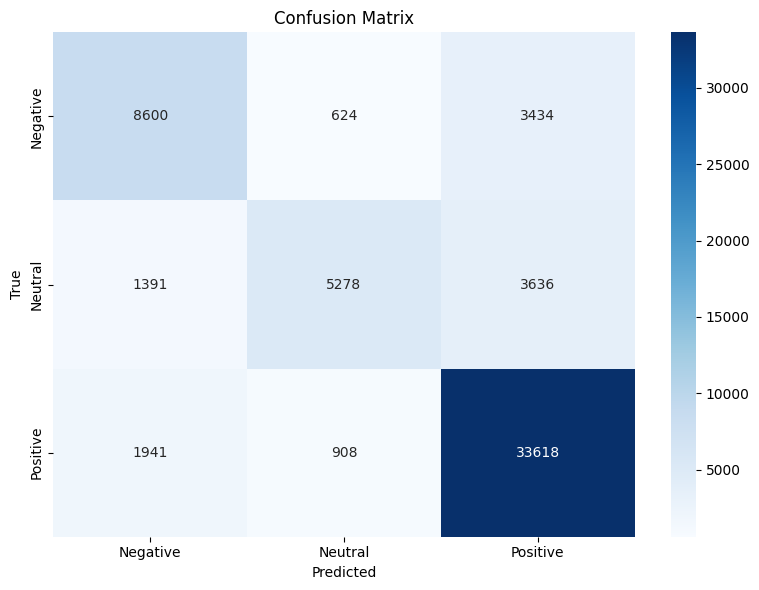


Accuracy by Aspect Length:
  Length 1: 0.7887 (count: 29835)
  Length 2: 0.8079 (count: 22355)
  Length 3: 0.8133 (count: 5120)
  Length 4: 0.8013 (count: 1424)
  Length 5: 0.8600 (count: 443)
  Length 6: 0.8767 (count: 146)
  Length 7: 0.8596 (count: 57)
  Length 8: 0.9200 (count: 25)
  Length 9: 0.8182 (count: 11)
  Length 10: 0.6667 (count: 6)
  Length 11: 0.8000 (count: 5)
  Length 12: 1.0000 (count: 1)
  Length 14: 0.0000 (count: 2)

Class Distribution - True vs Predicted:
  Negative: True=21.30%, Predicted=20.08%
  Neutral: True=17.34%, Predicted=11.46%
  Positive: True=61.36%, Predicted=68.46%


<ipython-input-54-8d142aac3f72>:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  length_groups = test_df_copy.groupby('aspect_length').apply(


In [55]:
print("\n======= Evaluating DistilBERT-ABSA Model Accuracy =======")
test_metrics = evaluate_model_performance(
    distilbert_absa_model,
    distilbert_test_dataloader,
    device,
    test_df
)

## Application of the best model to predict aspect-based sentiments

In [56]:
# Function to predict sentiment using DistilBERT for a text-aspect pair
def predict_sentiment_with_distilbert(text, aspect):
    # Prepare input
    combined_text = text + " " + distilbert_tokenizer.sep_token + " " + aspect
    encoding = distilbert_tokenizer.encode_plus(
        combined_text,
        add_special_tokens=True,
        max_length=MAX_SEQ_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get prediction
    with torch.no_grad():
        with safe_autocast():
            outputs = distilbert_absa_model(input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)

    return preds.item()

In [57]:
# Create distilbert predictions for all aspects in the dataframe
print("Predicting sentiment for all aspects using DistilBERT...")
aspect_neural_sentiments_list = []

for idx, row in tqdm(df_with_aspects.iterrows(), desc="Analyzing aspects with DistilBERT"):
    text = row['text']
    aspects = row['aspects']
    aspect_sentiments = {}

    for aspect in aspects:
        try:
            sentiment_class = predict_sentiment_with_distilbert(text, aspect)
            aspect_sentiments[aspect] = {
                'sentiment_class': sentiment_class,
                'model': 'distilbert'
            }
        except Exception as e:
            # If there's an error, fallback to VADER if available
            if aspect in row['aspect_sentiments']:
                vader_sentiment = row['aspect_sentiments'][aspect]['sentiment_class']
                aspect_sentiments[aspect] = {
                    'sentiment_class': vader_sentiment,
                    'model': 'vader (fallback)'
                }

    aspect_neural_sentiments_list.append(aspect_sentiments)

Predicting sentiment for all aspects using DistilBERT...


Analyzing aspects with DistilBERT: 0it [00:00, ?it/s]<ipython-input-53-34550305d05d>:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return autocast()
Analyzing aspects with DistilBERT: 99553it [1:28:21, 18.78it/s]


In [58]:
# Add neural model predictions to dataframe
df_with_aspects['neural_aspect_sentiments'] = aspect_neural_sentiments_list

## Generating insights from the best model


In [59]:
# Define aspect categories and their related terms
ASPECT_CATEGORIES = {
    "sound quality": ["sound", "audio", "sound quality", "audio quality", "clarity", "rich sound",
                     "excellent sound", "clear sound", "good sound", "bad sound"],
    "bass": ["bass", "bass response", "deep bass", "good bass", "heavy bass", "poor bass"],
    "comfort": ["comfort", "comfortable", "uncomfortable", "fit", "ergonomic", "ergonomics",
               "ear fit", "earbuds", "in-ear", "painful"],
    "price": ["price", "cost", "value", "cheap", "expensive", "worth", "value for money",
             "good value", "great value", "overpriced"],
    "battery": ["battery", "battery life", "charge", "charging", "battery duration",
               "long battery", "short battery"],
    "connection": ["bluetooth", "connection", "connectivity", "pairing", "disconnect",
                  "wireless", "connection issues"],
    "noise cancellation": ["noise", "noise cancellation", "anc", "noise isolation",
                          "background noise", "ambient"],
    "microphone": ["mic", "microphone", "call quality", "voice", "calls", "call", "talking"],
    "durability": ["durability", "build quality", "build", "quality", "sturdy", "flimsy",
                  "robust", "material", "construction"],
    "controls": ["controls", "buttons", "touch", "control", "touch controls", "volume control"],
    "design": ["design", "look", "appearance", "color", "stylish", "aesthetic", "sleek"]
}

# Create a reverse mapping for categorization
ASPECT_MAPPING = {}
for category, terms in ASPECT_CATEGORIES.items():
    for term in terms:
        ASPECT_MAPPING[term] = category

# List of generic sentiment adjectives to remove
SENTIMENT_ADJECTIVES = ["good", "great", "excellent", "best", "amazing", "awesome", "perfect",
                       "bad", "poor", "terrible", "worst", "awful", "horrible", "disappointing"]

In [60]:
def categorize_aspect(aspect):
    """Map an aspect to its standardized category"""
    aspect_lower = aspect.lower()

    # Try direct mapping first
    if aspect_lower in ASPECT_MAPPING:
        return ASPECT_MAPPING[aspect_lower]

    # Check if any category term is in the aspect
    for category, terms in ASPECT_CATEGORIES.items():
        for term in terms:
            if term in aspect_lower:
                return category

    # Try to match after removing sentiment adjectives
    cleaned_aspect = aspect_lower
    for adj in SENTIMENT_ADJECTIVES:
        cleaned_aspect = cleaned_aspect.replace(adj + " ", "").strip()

    if cleaned_aspect in ASPECT_MAPPING:
        return ASPECT_MAPPING[cleaned_aspect]

    # If no match, return "other"
    return "other"

In [61]:
# Function to calculate aspect sentiment statistics by product with categorization and scores
def analyze_product_aspect_sentiment(df, sentiment_column):
    # Group by product title
    product_aspect_analysis = {}

    # Get unique product titles
    unique_products = df['title'].unique()

    for product_title in unique_products:
        # Filter dataframe for this product
        product_df = df[df['title'] == product_title]

        # Initialize dictionaries for aspect categories
        aspect_categories = {category: {"positive": 0, "negative": 0, "neutral": 0, "total": 0, "aspects": []}
                            for category in ASPECT_CATEGORIES.keys()}
        aspect_categories["other"] = {"positive": 0, "negative": 0, "neutral": 0, "total": 0, "aspects": []}

        for idx, row in product_df.iterrows():
            aspects = row['aspects']
            aspect_sentiments = row[sentiment_column]

            for aspect in aspects:
                # Skip empty aspects
                if not aspect or pd.isna(aspect):
                    continue

                # Categorize the aspect
                category = categorize_aspect(aspect)

                # Keep track of original aspects for each category
                if aspect not in aspect_categories[category]["aspects"]:
                    aspect_categories[category]["aspects"].append(aspect)

                # Analyze sentiment if available
                if aspect in aspect_sentiments:
                    sentiment_data = aspect_sentiments[aspect]
                    sentiment_class = sentiment_data['sentiment_class']

                    # Increment the appropriate counter
                    if sentiment_class == 0:
                        aspect_categories[category]["negative"] += 1
                    elif sentiment_class == 1:
                        aspect_categories[category]["neutral"] += 1
                    else:
                        aspect_categories[category]["positive"] += 1

                    aspect_categories[category]["total"] += 1

        # Calculate sentiment scores for each category (0-10 scale)
        for category, data in aspect_categories.items():
            if data["total"] > 0:
                # Calculate net sentiment (-1 to 1 scale)
                net_sentiment = (data["positive"] - data["negative"]) / data["total"]

                # Keep the -1 to +1 scale as requested
                data["score"] = round(net_sentiment, 2)
            else:
                data["score"] = 0

        # Add to product analysis
        product_aspect_analysis[product_title] = aspect_categories

    return product_aspect_analysis

In [62]:
# Analyze sentiment with DistilBERT method
print("Analyzing aspect sentiment by product using DistilBERT with categorization and scores...")
product_neural_aspect_analysis = analyze_product_aspect_sentiment(df_with_aspects, 'neural_aspect_sentiments')

Analyzing aspect sentiment by product using DistilBERT with categorization and scores...


In [63]:
# Print aspect categories with frequencies and scores for each product
for product_title, categories in product_neural_aspect_analysis.items():
    print(f"\n===== Product: {product_title} =====")

    # Print aspects sorted by sentiment score (highest to lowest)
    print("\nAspect Categories by Sentiment Score (highest to lowest):")

    # Only include categories with mentions and exclude "other"
    mentioned_aspects = [(category, data) for category, data in categories.items()
                        if data["total"] > 0 and category != "other"]
    mentioned_aspects.sort(key=lambda x: x[1]["score"], reverse=True)

    for category, data in mentioned_aspects[:15]:  # Top 15 most mentioned
        score = data["score"]
        mentions = data["total"]
        print(f"- {category}: mentioned {mentions} times (score: {score} on -1 to +1 scale)")


===== Product: Apple AirPods (2nd Generation) Wireless Earbuds with Lightning Charging Case Included. Over 24 Hours of Battery Life, Effortless Setup. Bluetooth Headphones for iPhone =====

Aspect Categories by Sentiment Score (highest to lowest):
- durability: mentioned 563 times (score: 0.63 on -1 to +1 scale)
- sound quality: mentioned 2122 times (score: 0.62 on -1 to +1 scale)
- price: mentioned 746 times (score: 0.58 on -1 to +1 scale)
- comfort: mentioned 369 times (score: 0.57 on -1 to +1 scale)
- bass: mentioned 28 times (score: 0.54 on -1 to +1 scale)
- design: mentioned 79 times (score: 0.54 on -1 to +1 scale)
- noise cancellation: mentioned 696 times (score: 0.42 on -1 to +1 scale)
- connection: mentioned 445 times (score: 0.37 on -1 to +1 scale)
- battery: mentioned 1494 times (score: 0.31 on -1 to +1 scale)
- microphone: mentioned 489 times (score: 0.23 on -1 to +1 scale)
- controls: mentioned 35 times (score: 0.14 on -1 to +1 scale)

===== Product: Panasonic ErgoFit Wire